# Download Earthquake Waveforms
This notebook demonstrates the workflow to download earthquake waveforms using SeisGo functions (https://github.com/xtyangpsp/SeisGo). Specifically, we will import the `seisgo.downloaders` package to download earthquake information and the waveforms. To run this notebook, you can follow the instructions on the SeisGo github page to set up the environment.

In [2]:
from obspy import UTCDateTime,read_events
from seisgo import downloaders as dld
from seisgo import utils
import time

## 1. Get the information of the example seismic station
We use `seisgo.downloaders` function `get_sta_list()` to download the station list (a Pandas dateframe).


In [3]:
# =========================================================================
#Station list parameters
source = 'IRIS'
start = "2010-01-01"
end = "2021-06-01"

net='NM' # TA
sta='BLO' # SFIN
chan='BHZ'

#get station information first
starttime=UTCDateTime(start)
endtime=UTCDateTime(end)
stainfo=dld.get_sta_list(net,sta,chan,starttime=starttime,endtime=endtime)

## 2. Get the waveforms for example earthquakes at this station
In the cell below, we call `downloaders.get_events()` to download the earthquake catalog. Then we call `downloaders.get_event_waveforms` to download the seismic waveform segments for those earthquakes at the example station. This function returns a list of ObsPy Stream objects and a list of event id for the waveforms.

In [4]:
def get_events(start,end,lon,lat,radius,minmag,maxmag,magstep=1.0,source="USGS",v=False):
    #elist is a list of panda dataframes
    t0=time.time()

    #Download the catalog by magnitudes
    maglist=np.arange(minmag,maxmag+0.5*magstep,magstep)
    events=[]
    for i in range(len(maglist)-1):
        if i>0:
            minM=str(maglist[i]+0.0001) #to avoid duplicates with intersecting magnitude thresholds
        else:
            minM=str(maglist[i])
        maxM=str(maglist[i+1])
        if v: print(minM,maxM)
        if(source=="ISC"):
            quake_url="http://isc-mirror.iris.washington.edu/fdsnws/event/1/query?starttime="+\
            start+"&endtime="+end+"&latitude="+str(lat)+"&longitude="+str(lon)+"&maxradius="+\
            str(radius)+"&minmagnitude="+minM+"&maxmagnitude="+maxM+""
        elif(source=="USGS"):
            quake_url="https://earthquake.usgs.gov/fdsnws/event/1/query?format=xml&starttime="+\
            start+"&endtime="+end+"&minmagnitude="+minM+"&maxmagnitude="+maxM+"&latitude="+\
            str(lat)+"&longitude="+str(lon)+"&maxradius="+str(radius)+""

        try:
            event = read_events(quake_url)
            if v: print("Catalog: " + str(event.count()))
            events.append(event)
        except Exception as e:
            print(e)

    catalog = events[0]
    for i in np.arange(1,len(events)):
            catalog.extend(events[i])
    #Print the data frame, display total, and total time to complete task
    if v: print("It took "+str(time.time()-t0)+" seconds to download the catalog")

    return catalog

In [5]:
# start = "2015-01-01"
# end = "2018-01-01"
# minlat = 50
# maxlat = 74
# minlon=-175
# maxlon=-135
# minmag = 6
# maxmag = 10
# magstep = 2.0
# catalog = dld.get_events(start,end,minlon,maxlon,minlat,maxlat,minmag,maxmag,magstep)
# print(catalog)

In [6]:
#Download Catalog
start = "2010-01-01"
end = "2020-01-01"
lat = -31.573
lon = -71.674
radius = 10 # degrees
minmag = 6
maxmag = 10
magstep = 2.0
catalog = get_events(start,end,lon,lat,radius,minmag,maxmag,magstep)
print(catalog)

99 Event(s) in Catalog:
2019-12-24T16:43:33.420000Z | -26.964,  -63.386 | 6.0 mww | manual
2019-11-04T21:53:25.320000Z | -31.836,  -71.375 | 6.1 mww | manual
...
2015-09-16T22:54:32.860000Z | -31.573,  -71.674 | 8.3 mww | manual
2010-02-27T06:34:11.530000Z | -36.122,  -72.898 | 8.8 mww | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## The following example returns the earthquake waveforms in a list of ObsPy Trace objects. Set argument `savetofile=True` will save the data into HDF5 files.

`get_event_waveforms()` downloads one event at a time for all stations. We use a for loop here to download all earthquakes in the `catalog`.

In [7]:
# Downloading parameters
window_len = 100
offset = -20 #time before the first arrival
samp_freq=40
trall=[]
for event in catalog:
    tr=dld.get_event_waveforms(event,stainfo,window_len,offset,samp_freq=samp_freq,savetofile=False)
    if len(tr):
        print('downloading '+str(event.short_str()))
        trall.append(tr[0])
# it is okay if there is no data for some earthquakes. 

downloading 2019-12-24T16:43:33.420000Z | -26.964,  -63.386 | 6.0 mww | manual
downloading 2019-11-04T21:53:25.320000Z | -31.836,  -71.375 | 6.1 mww | manual
downloading 2019-09-29T15:57:53.236000Z | -35.476,  -73.163 | 6.7 mww | manual
downloading 2019-09-26T16:36:18.155000Z | -40.815,  -71.999 | 6.1 mww | manual
downloading 2019-08-01T18:28:07.270000Z | -34.236,  -72.310 | 6.8 mww | manual
downloading 2019-06-14T00:19:12.401000Z | -30.056,  -72.082 | 6.4 mww | manual
downloading 2019-01-20T01:32:52.480000Z | -30.040,  -71.382 | 6.7 mww | manual
downloading 2018-04-10T10:19:34.370000Z | -31.026,  -71.529 | 6.2 mww | manual
downloading 2017-04-24T21:38:30.820000Z | -33.038,  -72.062 | 6.9 mww | manual
downloading 2017-04-23T02:36:07.830000Z | -33.035,  -72.030 | 6.0 mww | manual
downloading 2017-04-15T08:19:43.390000Z | -23.265,  -67.722 | 6.3 mww | manual
downloading 2017-02-18T12:10:17.970000Z | -23.861,  -66.659 | 6.4 mww | manual
downloading 2016-11-20T20:57:44.000000Z | -31.623,  

## Single-linkage heirachical clustering using DTW distance matrix

In [8]:
# plt.plot(trall[12].data)
# plt.show()

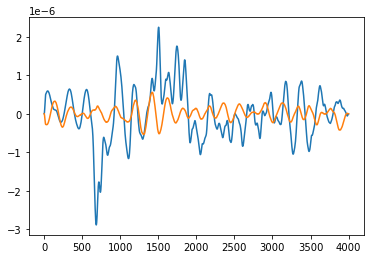

DTW distance array
[ 0.00088333  0.00125412  0.00090205 ...,  0.00073624  0.11236087
  0.11090615]


In [101]:
# print(trall[0].stats)
# trall[0].plot()

from dtw import *
import numpy as np
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

plt.plot(trall[0].data)
plt.plot(trall[2].data)
plt.show()

# Construct DTW distance matrix (very expensive!)
size = len(trall)
dtw_dist_matrix = np.zeros((size, size))
for i in range(size):
    query = trall[i]
    for j in range(i, size):
        template = trall[j]
        alignment = dtw(query, template, keep_internals=True)
        dtw_dist_matrix[i, j] = alignment.distance
        dtw_dist_matrix[j, i] = alignment.distance
# print("DTW distance matrix")
# print(dtw_dist_matrix)

# Convert the redundant n*n square matrix form into a condensed nC2 array
# distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
dtw_dist_array = ssd.squareform(dtw_dist_matrix)
print("DTW distance array")
print(dtw_dist_array)

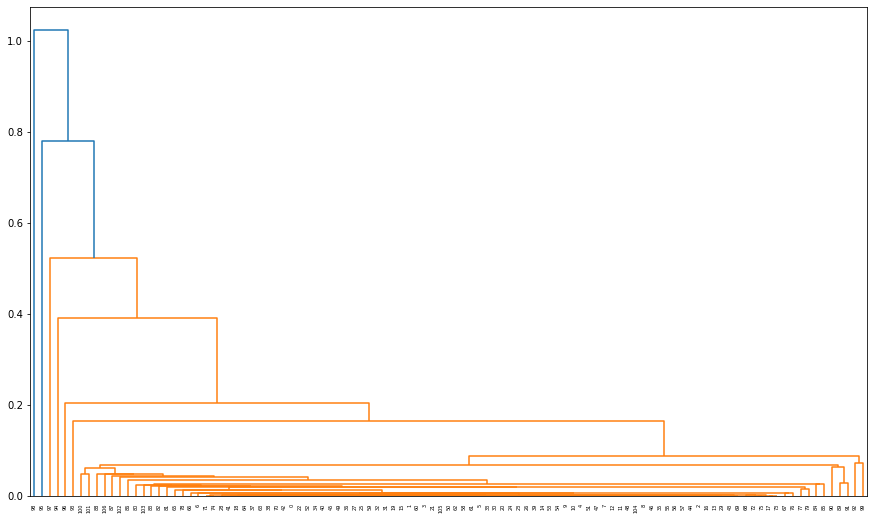

In [105]:
# Plot dendogram
fig = plt.figure(figsize=(15, 9))
dn = dendrogram(linkage(dtw_dist_array, 'single'))
plt.show()

In [115]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

k = 2
h_clustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
pred = h_clustering.fit_predict(dtw_dist_array.reshape(-1, 1))
print(pd.Series(pred).value_counts())

0    5360
1     311
dtype: int64


## tslearn

(15, 4000, 1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    4.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.0s finished


0.000 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.2s finished


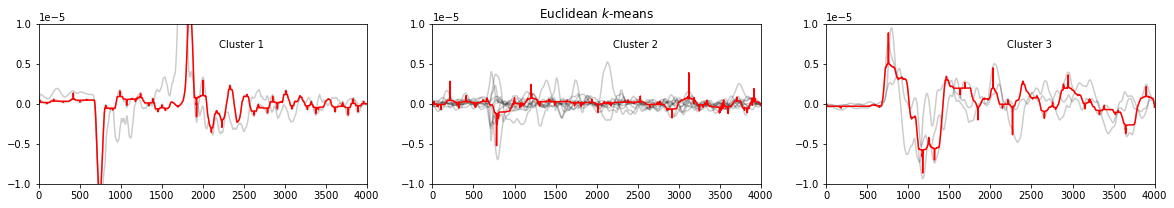

In [103]:
from tslearn.utils import to_time_series, to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

X_train = to_time_series_dataset([tr.data for tr in trall[:15]])
print(X_train.shape)

k = 3
km = TimeSeriesKMeans(n_clusters=k, metric="dtw",
                      verbose=True, max_iter_barycenter=10, random_state=0)
y_pred = km.fit_predict(X_train)
plt.figure(figsize=(20, 10))
for yi in range(k):
    plt.subplot(k, k, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train.shape[1])
    plt.ylim(-0.00001, 0.00001)
    plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.show()

In [104]:
print(km.labels_)
cluster_indices = {}
for i in range(len(km.labels_)):
    label = km.labels_[i]
    if label in cluster_indices:
        cluster_indices[label].append(i)
    else:
        cluster_indices[label] = [i]
print(cluster_indices) # remove other cluster members then rerun

[1 1 2 1 2 1 0 1 2 1 1 1 0 1 1]
{1: [0, 1, 3, 5, 7, 9, 10, 11, 13, 14], 2: [2, 4, 8], 0: [6, 12]}


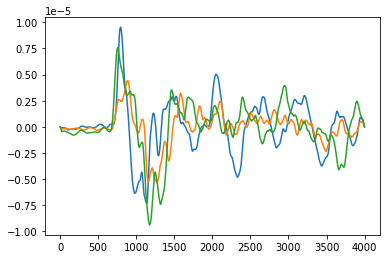

In [105]:
plt.plot(trall[2])
plt.plot(trall[4])
plt.plot(trall[8])

## Plotting earthquake locations

/Users/nikhildsouza/opt/miniconda3/envs/seisgo/lib/python3.9/site-packages/obspy/imaging/maps.py:762: MatplotlibDeprecationWarning:

The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.



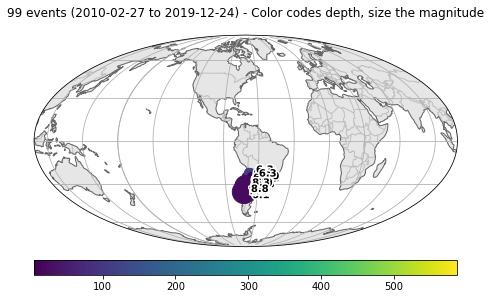

Figure(432x288)


In [184]:
import cartopy.crs as ccrs
print(catalog.plot())

In [194]:
import pandas as pd
import plotly.express as px

# Convert catalog to dataframe
rows = []
for event in catalog.__iter__():
    rows.append([
        event.event_descriptions[0].text,
        event.origins[0].time,
        event.origins[0].longitude,
        event.origins[0].latitude,
        event.origins[0].depth,
        event.magnitudes[0].mag
    ])
catalog_df = pd.DataFrame(rows, columns=['desc', 'time', 'lon', 'lat', 'depth', 'mag'])
catalog_df = catalog_df.sort_values(by='time')
catalog_df['year'] = catalog_df['time'].apply(lambda v: v.year)

# Create map using plotly
fig = px.scatter_mapbox(
    catalog_df,
    lat="lat",
    lon='lon',
    hover_name="desc",
    hover_data=catalog_df.columns,
    color="mag",
    size="mag",
    size_max=13,
    range_color=[minmag, maxmag],
    center=dict(lon=catalog_df.iloc[0]['lon'], 
             lat=catalog_df.iloc[0]['lat']),
    zoom=3,
    animation_frame="year",
    width=900,
    height=800,
)
                     
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
        }
    ]
)
fig.show()

## Plotting waveforms

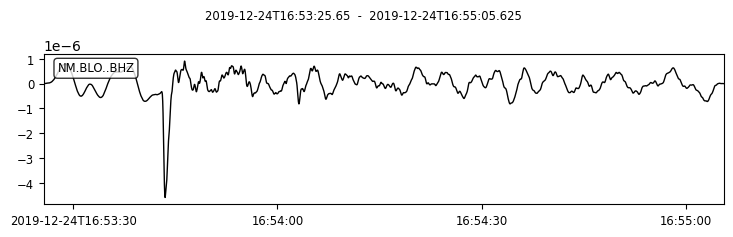

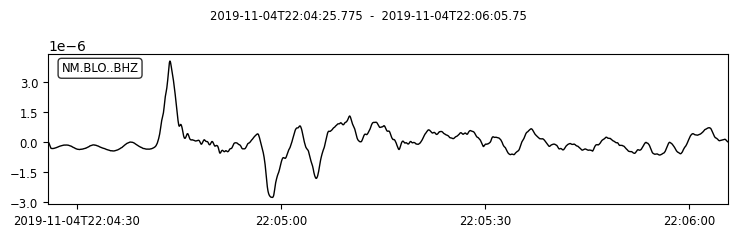

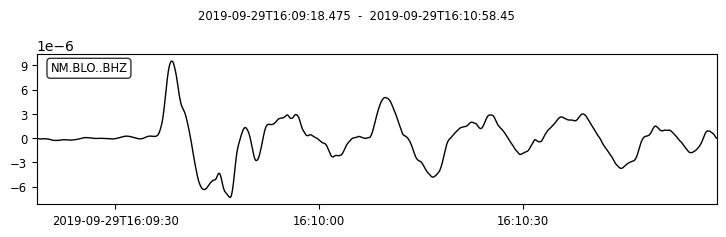

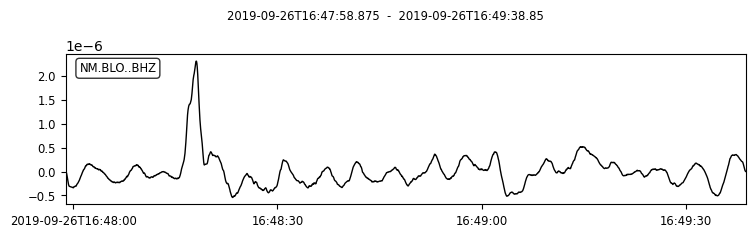

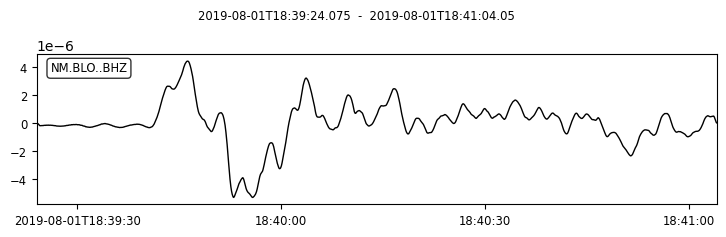

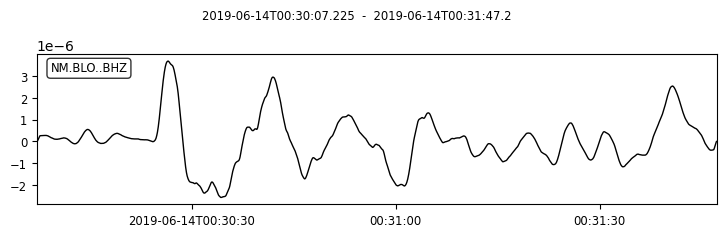

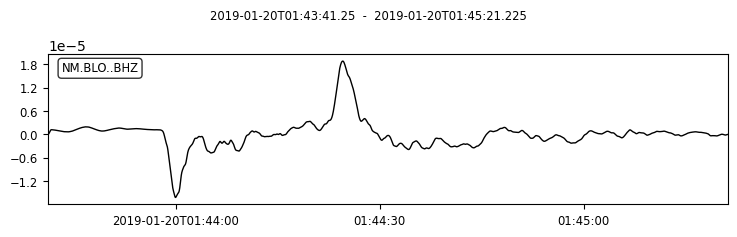

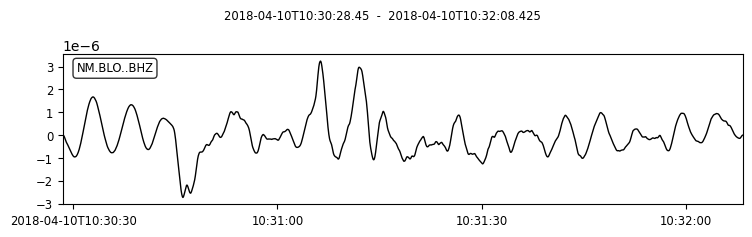

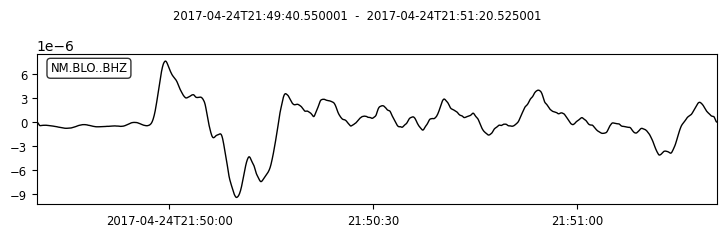

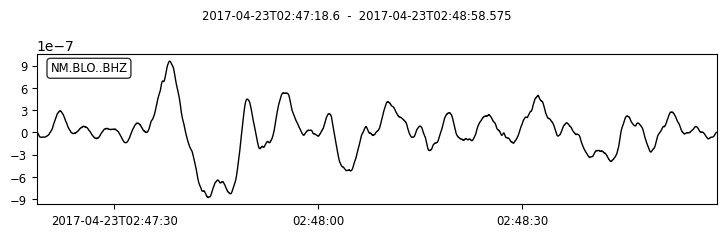

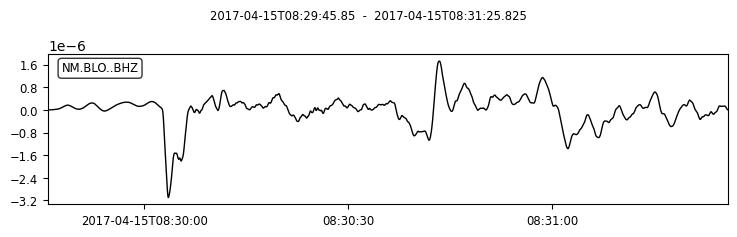

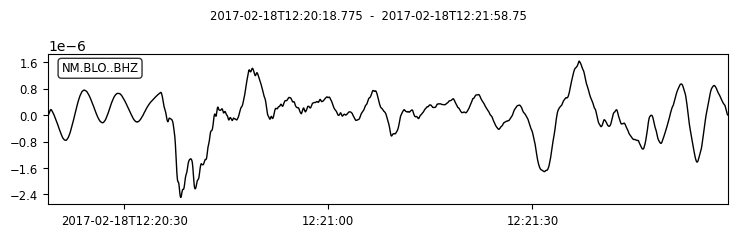

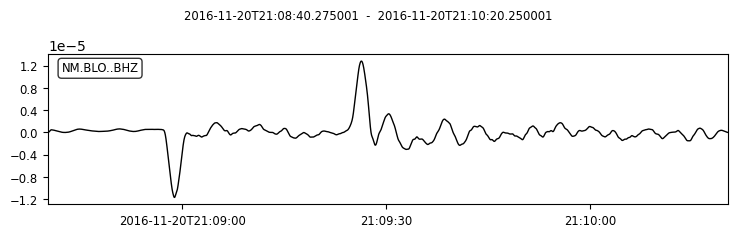

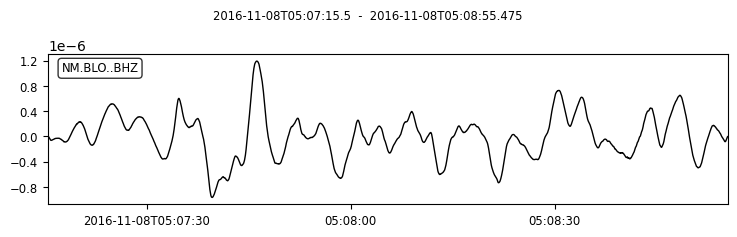

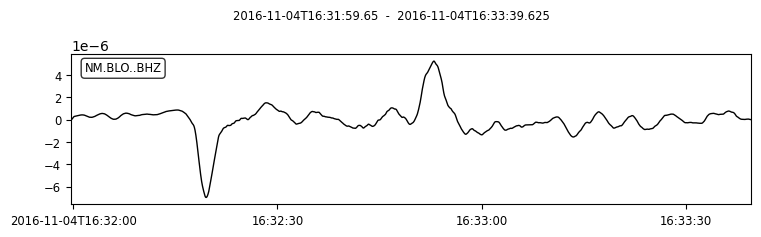

In [106]:
######write your codes here
for tr in trall[:15]:
    tr.plot();


### `seisgo.utils` also has a simple plotting function `plot_trace`. The current version of this plots the x-axis as the relative time starting from zero. It doesn't yet consider the absolute date and time.

The default mode is "subplot". mode='overlap' will plot all traces on the same figure, which is useful for the purpose of comparison.

station NM.BLO
station NM.BLO
station NM.BLO
station NM.BLO


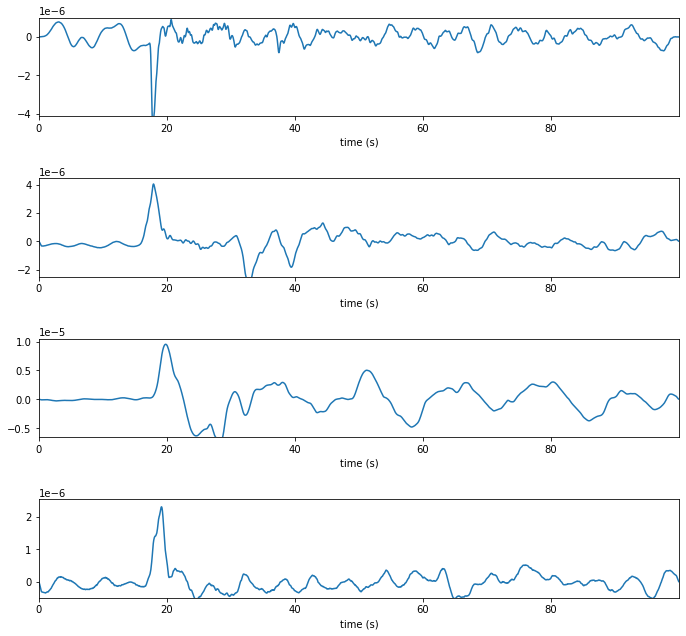

In [107]:
utils.plot_trace(trall[:4],mode='subplot') #